## Distracted Driver Recognition - Deep learning

Part 5 includes the saliency maps

Used with tensorflow 1.14.0 and keras 2.3.1 (otherwise it will throw errors)


<a id="section-one"></a>
# Part 1: Importing the libraries

In [33]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
from vis.visualization import visualize_saliency
from vis.utils import utils

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

#CNN
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

#VIS
from keras.utils.vis_utils import plot_model
print("Done")

Done


<a id="section-two"></a>
# Part 2: Preprocessing

In [10]:
def _prepareData(path): 
    '''
    params: path(string)
    return: [list list] of images in dataset and the list of labels
    '''
    labelsList = []
    listOfimg = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for img in glob.glob(os.path.join(directory,'*.jpg')):
                imgcv = cv2.imread(img)
                imgcv_r = cv2.resize(imgcv,(128,128)) #Resize to 128,128
                listOfimg.append(imgcv_r)
                labelsList.append(int(directory.split("\\")[-1].replace('c','')))
    
    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(listOfimg,labelsList, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

In [11]:
'''#Paths
pathTrainImages = "kaggle/input/state-farm-distracted-driver-detection/img/train/"
pathPropagateImages =  "kaggle/input/state-farm-distracted-driver-detection/img/test/"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrainImages)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))
'''
#Paths
pathTrain_Images = "kaggle/input/imgs/train/"
#pathPropagate_Images =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrain_Images)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


<a id="section-three"></a>
# Part 3: EDA

<a id="threeone"></a>
# Part 3.1: Statistics

<bound method NDFrame.head of       subject classname            img
0        p002        c0  img_44733.jpg
1        p002        c0  img_72999.jpg
2        p002        c0  img_25094.jpg
3        p002        c0  img_69092.jpg
4        p002        c0  img_92629.jpg
...       ...       ...            ...
22419    p081        c9  img_56936.jpg
22420    p081        c9  img_46218.jpg
22421    p081        c9  img_25946.jpg
22422    p081        c9  img_67850.jpg
22423    p081        c9   img_9684.jpg

[22424 rows x 3 columns]>

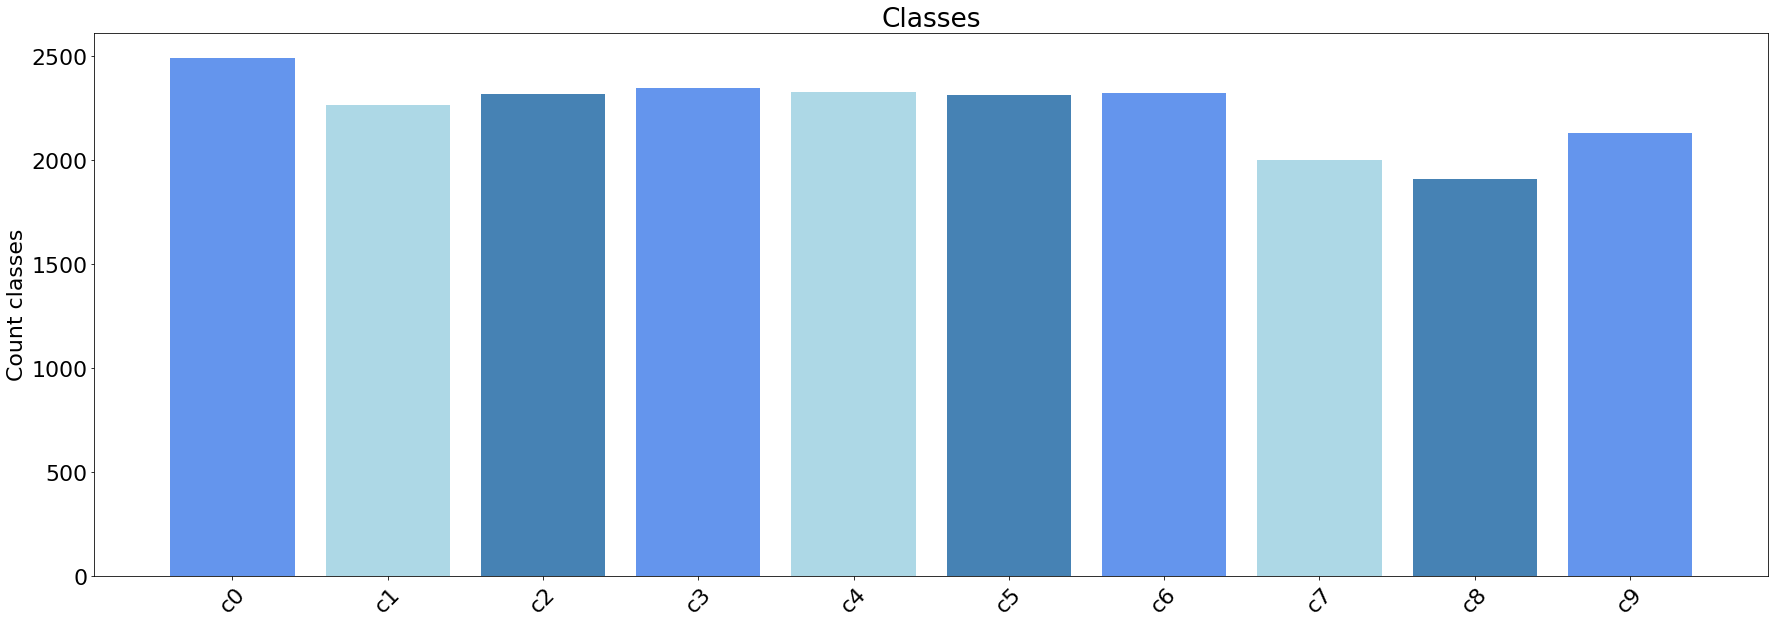

In [12]:
data_file = pd.read_csv("kaggle/input/driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])

# Parámetros de ploteo (Se va a generar un plot diferente para cada Clase)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)
data_file.head

<a id="threetwo"></a>
# Part 3.2: Visualization

In [13]:
import plotly.express as px

px.histogram(data_file, x="classname", color="classname", title="Number of images by categories ")

ModuleNotFoundError: No module named 'plotly'

In [6]:
# Find the frequency of images per driver
driversID = pd.DataFrame((data_file['subject'].value_counts()).reset_index())
driversID.columns = ['driver_id', 'Counts']
px.histogram(driversID, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

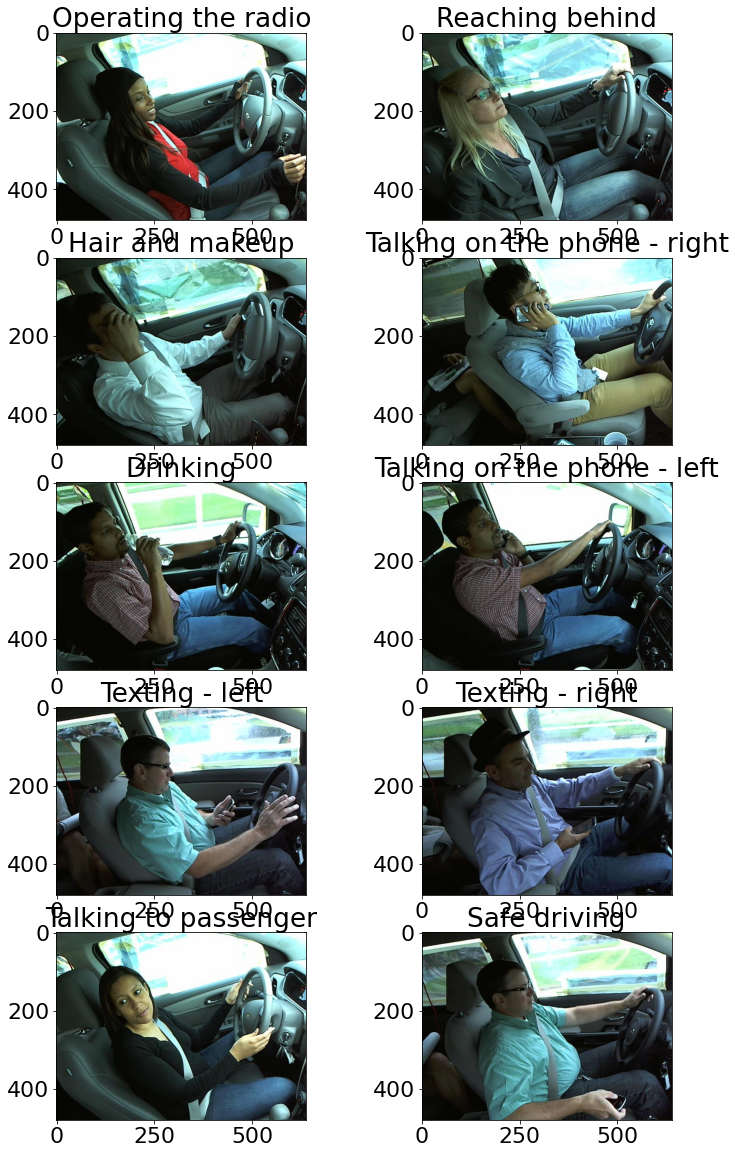

In [7]:
categories = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../input/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(categories[directory])

<a id="section-four"></a>
# Part 4: ANN

<a id="fourone"></a>
## Part 4.1: Creating the Model

In [261]:
model = keras.models.Sequential()

#model.add(keras.layers.InputLayer(
   # input_shape=(128, 128, 3)
#))


#model.add(keras.layers.Dense(units=512, activation='relu',name = 'fc_1', input_shape=(128, 128, 3)))
model.add(keras.layers.Flatten(input_shape=(128, 128, 3)))
#model.add(keras.layers.Dense(units=1024, activation='relu',name = 'fc_1'))
#model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512, activation='relu',name = 'fc_2'))
model.add(keras.layers.Dense(units=10,activation = None,name = 'fc_3')) # layer without activation
model.add(layers.Activation(activations.softmax)) # extra layer with activation

#model.compute_output_shape(input_shape=(256,8,8,1))

In [262]:
#tf.random.set_seed(1) # only for newer tensor flow versions
tf.random.set_random_seed(1)
#model.build(input_shape=(None,128,128,3))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 49152)             0         
_________________________________________________________________
fc_2 (Dense)                 (None, 512)               25166336  
_________________________________________________________________
fc_3 (Dense)                 (None, 10)                5130      
_________________________________________________________________
activation_14 (Activation)   (None, 10)                0         
Total params: 25,171,466
Trainable params: 25,171,466
Non-trainable params: 0
_________________________________________________________________
None


<a id="train-model"></a>
## Part 4.2: Training the Model

In [263]:
history = model.fit(x = X_Train, y=Y_Train,epochs = 7, batch_size = 500, verbose = 1,validation_split=0.2)

Train on 14351 samples, validate on 3588 samples
Epoch 1/7
14351/14351 [==============================] - 34s 2ms/step - loss: 12717.2475 - accuracy: 0.1293 - val_loss: 1270.2854 - val_accuracy: 0.2341
Epoch 2/7
14351/14351 [==============================] - 22s 2ms/step - loss: 513.0010 - accuracy: 0.2452 - val_loss: 200.5580 - val_accuracy: 0.3163
Epoch 3/7
14351/14351 [==============================] - 19s 1ms/step - loss: 73.2819 - accuracy: 0.5049 - val_loss: 31.4813 - val_accuracy: 0.6054
Epoch 4/7
14351/14351 [==============================] - 20s 1ms/step - loss: 19.0889 - accuracy: 0.7323 - val_loss: 8.4068 - val_accuracy: 0.8406
Epoch 5/7
14351/14351 [==============================] - 21s 1ms/step - loss: 5.0178 - accuracy: 0.8814 - val_loss: 3.9139 - val_accuracy: 0.8921
Epoch 6/7
14351/14351 [==============================] - 20s 1ms/step - loss: 2.5740 - accuracy: 0.9282 - val_loss: 3.1709 - val_accuracy: 0.9022
Epoch 7/7
14351/14351 [==============================] - 19s 

<a id="test-model"></a>
## Part 4.3: Evaluating the Model

In [264]:
test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)
save = model
print(test_loss)
print(test_acc)

4485/4485 [==============================] - 5s 1ms/step
3.1999928262048383
0.8974359035491943


<a id="test-model"></a>
## Part 5 saliency maps

In [293]:
# Find the index of the to be visualized layer above
from keras import activations
layer_idx = utils.find_layer_idx(model, 'fc_3')
print(layer_idx)

# Swap softmax with linear

#a = keras.models.load_model("model")
model.layers[layer_index].activation = activations.linear
#model = utils.apply_modifications(model)

2


In [310]:
input_test = X_Test
target_test = Y_Test


In [383]:
from vis.visualization import visualize_saliency
index_to_visualize = 1066# choose an example
img = input_test[index_to_visualize]
y_pred            = model.predict(img[np.newaxis,...])

class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
topNclass         = 10
classlabel = ["c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred[0,idx]))
from vis.visualization import visualize_saliency
class_idx = class_idxs_sorted[0]
grad_top1 = visualize_saliency(model,
                               layer_idx,
                               filter_indices = class_idx,
                               seed_input     = img[np.newaxis,...])

categories = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

Top 1 predicted class:     Pr(Class=c2                 [index=2])=1.000
Top 2 predicted class:     Pr(Class=c1                 [index=1])=0.000
Top 3 predicted class:     Pr(Class=c8                 [index=8])=0.000
Top 4 predicted class:     Pr(Class=c9                 [index=9])=0.000
Top 5 predicted class:     Pr(Class=c7                 [index=7])=0.000
Top 6 predicted class:     Pr(Class=c6                 [index=6])=0.000
Top 7 predicted class:     Pr(Class=c5                 [index=5])=0.000
Top 8 predicted class:     Pr(Class=c4                 [index=4])=0.000
Top 9 predicted class:     Pr(Class=c3                 [index=3])=0.000
Top 10 predicted class:     Pr(Class=c0                 [index=0])=0.000


In [297]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(img)
    axes[1].imshow(img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))

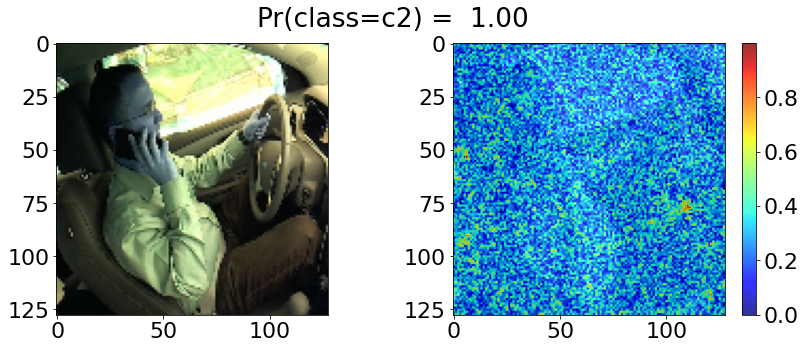

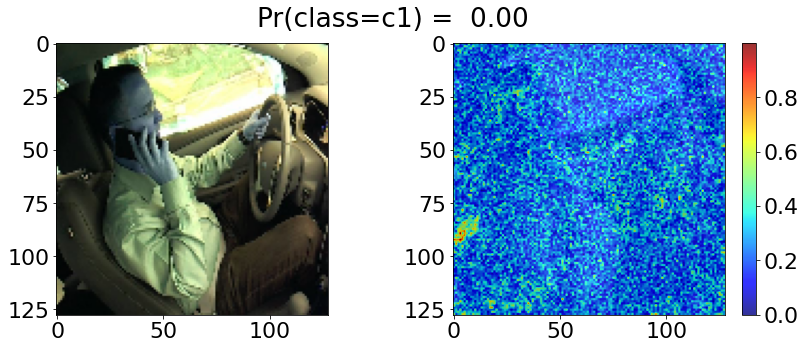

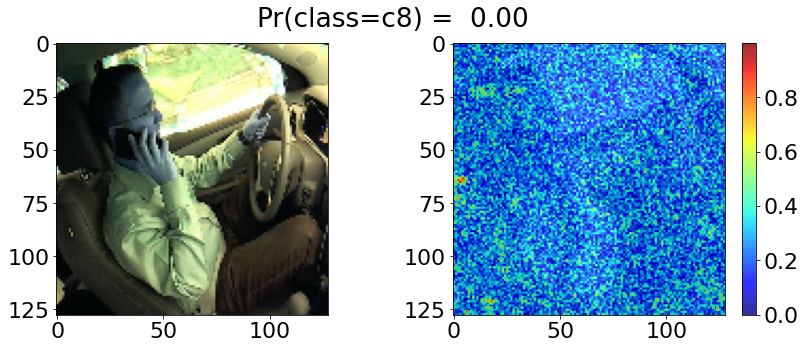

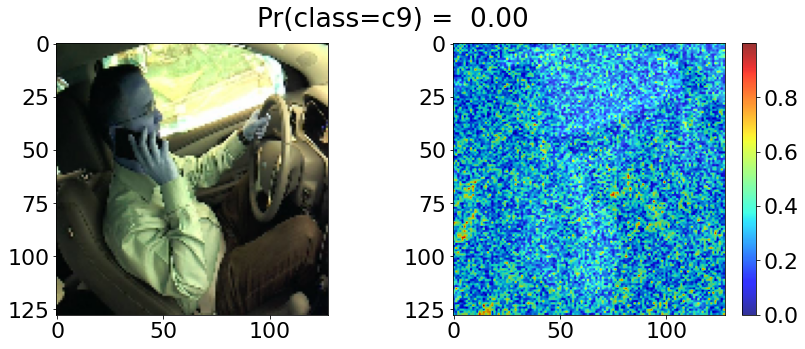

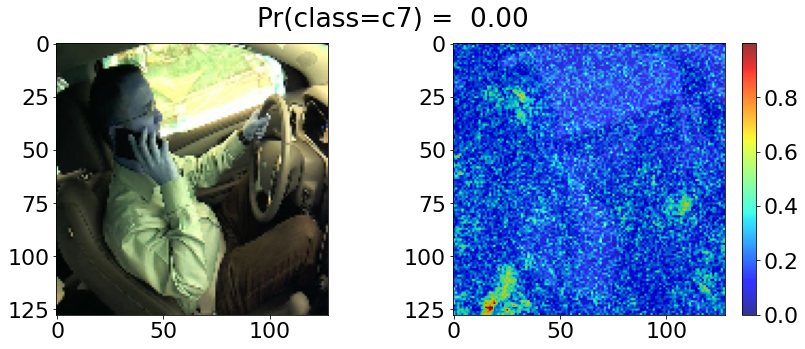

In [384]:
for class_idx in class_idxs_sorted[:5]:
    grads  = visualize_saliency(model,
                               layer_idx,
                               filter_indices = class_idx,
                               seed_input     = img[np.newaxis,...])
    plot_map(grads)
